# Master Parcel Analysis Table (MPAT) Exploratory Data Analysis
Author: Alemarie Ceria <br>
Last Updated: 02/24/26

## Overview

- Pilot area: Maui
- Source data: `mpat_v02_32604.gpkg` (7,505 x 31 columns)
- CRS: EPSG:32604 (UTM Zone 4N, meters) > EPSG:4326 (WGS 84)
- Purpose: Exploratory data analysis of cesspool replacement suitability variables at the parcel level

## Setup

### Imports

In [1]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from anymap_ts import Map
import numpy as np
from pathlib import Path
from IPython.display import display

# Load helper functions
%run ../src/eda.py

### Configurations

In [2]:
# Current MPAT version
VERSION = "02"

# Maui map center (WGS84)
MAUI_CENTER = {"lon": -156.3314, "lat": 20.7986}
MAUI_ZOOM = 9.45
MAUI_BBOX = ((-156.70, 20.45, -155.95, 21.05))  # (minx, miny, maxx, maxy)

MAP_DEFAULTS = dict(
    mapbox_style=COLORS["mapbox_style"],
    mapbox_zoom=MAUI_ZOOM,
    mapbox_center=MAUI_CENTER,
    margin=dict(l=0, r=0, t=40, b=0),
    height=550,
)

### Paths

In [3]:
# Project root (assumes notebook is in `project/notebooks/`)
project_root = Path.cwd().parent

# Directories
prepared_dir = project_root / "data" / "01_inputs" / "prepared"
interim_dir = project_root / "data" / "02_interim"
output_dir  = project_root / "data" / "03_processed"

### Data Sources

In [4]:
# All inputs
inputs = {
    # MPAT
    "mpat": {"path": output_dir  / "mpat_v02_32604.gpkg", "layer": "mpat_v02"},
    # Interim
    "building_fp_per_parcel": {"path": interim_dir / "20260225_building_fps_per_parcel.gpkg", "layer": "20260225_building_fps_per_parcel"},
    "analysis_pts": {"path": interim_dir / "20260225_analysis_points.gpkg", "layer": "20260225_analysis_points"},
    # Prepared vectors
    "coastline": {"path": prepared_dir / "coastline_hi_op_32604.gpkg", "layer": "coastline"},
    "sma": {"path": prepared_dir / "sma_hi_op_32604.gpkg", "layer": "sma"},
    "streams": {"path": prepared_dir / "streams_hi_hcpt_32604.gpkg", "layer": "streams"},
    "wells_dom": {"path": prepared_dir / "wells_dom_hi_hcpt_32604.gpkg", "layer": "wells_dom"},
    "wells_mun": {"path": prepared_dir / "wells_mun_hi_hcpt_32604.gpkg", "layer": "wells_mun"},
    "flood_zones": {"path": prepared_dir / "flood_zones_hi_op_32604.gpkg", "layer": "flood_zones"},
}

### Load Data

In [5]:
mpat_gdf = load_gdf(inputs["mpat"])
mpat_df = mpat_gdf.drop(columns="geometry")
building_fp_per_parcel_gdf = load_gdf(inputs["building_fp_per_parcel"], drop_cols=["building_fp_area_sqft"])
analysis_pts_gdf = load_gdf(inputs["analysis_pts"])
coastline_gdf = load_gdf(inputs["coastline"], maui_only=True)
sma_gdf = load_gdf(inputs["sma"], maui_only=True)
streams_gdf = load_gdf(inputs["streams"], maui_only=True)
wells_dom_gdf = load_gdf(inputs["wells_dom"], maui_only=True)
wells_mun_gdf = load_gdf(inputs["wells_mun"], maui_only=True)
flood_zones_gdf = load_gdf(inputs["flood_zones"], maui_only=True)

mpat_v02_32604                                  7,505 rows × 32 columns | CRS: EPSG:4326
20260225_building_fps_per_parcel               14,540 rows ×  2 columns | CRS: EPSG:4326
20260225_analysis_points                        7,505 rows ×  3 columns | CRS: EPSG:4326
coastline_hi_op_32604                               5 rows ×  6 columns | CRS: EPSG:4326
sma_hi_op_32604                                     3 rows ×  4 columns | CRS: EPSG:4326
streams_hi_hcpt_32604                           1,429 rows × 14 columns | CRS: EPSG:4326


c:\Users\apc\miniconda3\envs\geo\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: Non-conformant content for record 220 in column WCR, 2009-06-30T00:00:00.0Z, successfully parsed
  return ogr_read(
c:\Users\apc\miniconda3\envs\geo\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: Non-conformant content for record 316 in column TEST_DATE, 1970-11-17T00:00:00.0Z, successfully parsed
  return ogr_read(


wells_dom_hi_hcpt_32604                            95 rows × 69 columns | CRS: EPSG:4326
wells_mun_hi_hcpt_32604                            81 rows × 69 columns | CRS: EPSG:4326
flood_zones_hi_op_32604                         1,349 rows × 24 columns | CRS: EPSG:4326


## Data Quality Overview

In [6]:
# Build completeness summary (only fields with any nulls)
null_counts = mpat_df.isnull().sum()
null_pct = (null_counts / len(mpat_df) * 100).round(2)

completeness_df = (
    # Create pandas dataframe
    pd.DataFrame({"n_missing": null_counts, "pct_missing": null_pct})
    # Filter to columns with missing values
    .query("n_missing > 0")
    # Sort by descending
    .sort_values("n_missing", ascending=False)
    .reset_index()
    .rename(columns={"index": "field"})
)

# Annotations explaining why each field has nulls
notes = {
    "building_fp_qty": "306 parcels with no building footprints (structural, not data loss)",
    "building_fp_total_area_sqft": "306 parcels with no building footprints (structural, not data loss)",
    "net_parcel_area_sqft": "Derived from building_fp_total_area_sqft (inherits nulls)",
    "wt_elev_ft": "Raster NoData at parcel location (no values for east Maui)",
    "depth_to_wt_ft": "Derived from depth_to_wt_ft (inherits nulls)",
    "depth_to_wt_suitability": "Derived from depth_to_wt_ft (inherits nulls)",
    "ksat_h": "3 parcels outside NRCS soils layer extent",
    "ksat_l": "3 parcels outside NRCS soils layer extent",
    "ksat_r": "3 parcels outside NRCS soils layer extent",
    "land_surface_elev_ft": "1 parcel outside DEM extent",
    "slope_pct": "1 parcel outside DEM extent",
    "slope_req": "Derived from slope_pct (inherits null)",
}
completeness_df["note"] = completeness_df["field"].map(notes)

# Build table
fig = go.Figure(
    go.Table(
        columnwidth=[180, 80, 80, 350],
        header=dict(
            values=["<b>Field</b>", "<b>n missing</b>", "<b>% missing</b>", "<b>Note</b>"],
            fill_color=COLORS["accent"],
            font=dict(color="white", size=13),
            align="left",
        ),
        cells=dict(
            values=[
                completeness_df["field"],
                completeness_df["n_missing"],
                completeness_df["pct_missing"].astype(str) + "%",
                completeness_df["note"],
            ],
            fill_color=[["#f2f6fb" if i % 2 == 0 else "white" for i in range(len(completeness_df))]],
            align="left",
            font=dict(size=12),
            height=28,
        ),
    )
)

# Auto-size height: header (~40px) + each row (~30px) + title space
n_rows = len(completeness_df)
fig_height = 40 + (n_rows * 30) + 115

fig.update_layout(
    **make_layout(t=100, b=5),
    title=make_title(
        "Data Completeness",
        "Fields with missing values — MPAT pilot (Maui) | Total columns: 31",
        y=0.9
    ),
    height=fig_height,
)

fig.show()

Are we able to get a better water table raster that covers the entire island of Maui, not just the west side?

## Summary Statistics

Data types:

In [7]:
print("\nDataFrame info:")
mpat_df.info()


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7505 entries, 0 to 7504
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   island                       7505 non-null   object 
 1   tmk                          7505 non-null   object 
 2   osds_qty                     7505 non-null   int32  
 3   bedroom_qty                  7505 non-null   int64  
 4   building_fp_qty              7199 non-null   float64
 5   parcel_area_sqft             7505 non-null   float64
 6   building_fp_total_area_sqft  7199 non-null   float64
 7   net_parcel_area_sqft         7199 non-null   float64
 8   dist_to_sma_ft               7505 non-null   float64
 9   dist_to_coast_ft             7505 non-null   float64
 10  dist_to_streams_ft           7505 non-null   float64
 11  dist_to_dom_well_ft          7505 non-null   float64
 12  dist_to_mun_well_ft          7505 non-null   float64
 13  k

In [8]:
# Continuous variables summary table

BINARY_COLS = ["in_flood_zone", "in_sma", "coast_within_100_ft", "stream_within_50_ft"]

num_cols = [
    c for c in mpat_df.select_dtypes("number").columns
    if c not in BINARY_COLS
]

num_summary = (
    mpat_df[num_cols]
    .describe()
    .T
    .rename(columns={
        "count": "n", "mean": "mean", "std": "std",
        "min": "min", "25%": "p25", "50%": "median", "75%": "p75", "max": "max",
    })
    .reset_index()
    .rename(columns={"index": "field"})
)

num_summary["n_missing"] = mpat_df[num_cols].isnull().sum().values
num_summary["n"] = num_summary["n"].astype(int)
num_summary["n_missing"] = num_summary["n_missing"].astype(int)

for col in ["mean", "std", "min", "p25", "median", "p75", "max"]:
    num_summary[col] = num_summary[col].round(2)

num_summary = num_summary[["field", "n", "n_missing", "min", "p25", "median", "mean", "p75", "max", "std"]]

n_rows = len(num_summary)

fig = go.Figure(go.Table(
    columnwidth=[220, 60, 100, 100, 100, 100, 100, 100, 120, 100],
    header=dict(
        values=[f"<b>{c}</b>" for c in num_summary.columns],
        fill_color=COLORS["accent"],
        font=dict(color="white", size=13),
        align="left",
        height=36,
    ),
    cells=dict(
        values=[num_summary[c] for c in num_summary.columns],
        fill_color=[["#f2f6fb" if i % 2 == 0 else "white" for i in range(n_rows)]],
        align="left",
        font=dict(size=12),
        height=28,
    ),
))

fig.update_layout(
    **make_layout(t=90, b=5, l=35),
    title=make_title(
        "Continuous Variables Summary Statistics",
        f"MPAT pilot (Maui) | {len(num_cols)} continuous fields",
        y=0.93,
    ),
    height=40 + (n_rows * 28) + 130,
)

fig.show()

In [9]:
# Categorical variables summary table

cat_cols = [
    c for c in mpat_df.select_dtypes("object").columns
    if c not in BINARY_COLS
]

MAX_VALUES_LEN = 80

cat_rows = []
for col in cat_cols:
    s = mpat_df[col]
    vc = s.value_counts()

    if col == "tmk":
        values_str = f"All {s.nunique():,} values unique — TMK identifiers"
    else:
        raw = ", ".join(vc.index.astype(str).tolist())
        values_str = raw if len(raw) <= MAX_VALUES_LEN else raw[:MAX_VALUES_LEN] + "…"

    cat_rows.append({
        "field":     col,
        "n":         s.notnull().sum(),
        "n_missing": s.isnull().sum(),
        "n_unique":  s.nunique(),
        "top_value": vc.index[0] if len(vc) > 0 else None,
        "top_n":     int(vc.iloc[0]) if len(vc) > 0 else None,
        "top_%":     round(vc.iloc[0] / s.notnull().sum() * 100, 1) if len(vc) > 0 else None,
        "values":    values_str,
    })

cat_summary = pd.DataFrame(cat_rows)
n_rows = len(cat_summary)

fig = go.Figure(go.Table(
    columnwidth=[180, 60, 100, 90, 180, 60, 60, 300],
    header=dict(
        values=[f"<b>{c}</b>" for c in cat_summary.columns],
        fill_color=COLORS["accent"],
        font=dict(color="white", size=13),
        align="left",
        height=36,
    ),
    cells=dict(
        values=[cat_summary[c] for c in cat_summary.columns],
        fill_color=[["#f2f6fb" if i % 2 == 0 else "white" for i in range(n_rows)]],
        align="left",
        font=dict(size=12),
        height=28,
    ),
))

fig.update_layout(
    **make_layout(t=90, b=5, l=35),
    title=make_title(
        "Categorical Variables Summary Statistics",
        f"MPAT pilot (Maui) | {len(cat_cols)} categorical fields",
        y=0.9,
    ),
    height=90 + (n_rows * 28) + 130,
)

fig.show()

In [10]:
# Binary flag variables summary table

n_total = len(mpat_df)

flag_rows = []
for col in BINARY_COLS:
    s = mpat_df[col]
    n_pos = int(s.sum())
    flag_rows.append({
        "flag":       col,
        "n_total":    n_total,
        "n_missing":  int(s.isnull().sum()),
        "n (= 1)":    n_pos,
        "% (= 1)":    round(n_pos / n_total * 100, 2),
        "n (= 0)":    n_total - n_pos,
        "% (= 0)":    round((n_total - n_pos) / n_total * 100, 2),
    })

flag_summary = pd.DataFrame(flag_rows)
n_rows = len(flag_summary)

fig = go.Figure(go.Table(
    columnwidth=[200, 80, 80, 80, 80, 80, 80],
    header=dict(
        values=[f"<b>{c}</b>" for c in flag_summary.columns],
        fill_color=COLORS["accent"],
        font=dict(color="white", size=13),
        align="left",
        height=36,
    ),
    cells=dict(
        values=[
            flag_summary["flag"],
            flag_summary["n_total"].apply(lambda x: f"{x:,}"),
            flag_summary["n_missing"],
            flag_summary["n (= 1)"].apply(lambda x: f"{x:,}"),
            flag_summary["% (= 1)"].astype(str) + "%",
            flag_summary["n (= 0)"].apply(lambda x: f"{x:,}"),
            flag_summary["% (= 0)"].astype(str) + "%",
        ],
        fill_color=[["#f2f6fb" if i % 2 == 0 else "white" for i in range(n_rows)]],
        align="left",
        font=dict(size=12),
        height=28,
    ),
))

fig.update_layout(
    **make_layout(t=70, l=35, b=2),
    title=make_title(
        "Binary Flag Variables Summary Statistics",
        f"MPAT pilot (Maui) | {len(BINARY_COLS)} binary flags",
        y=0.88,
    ),
    height=20 + (n_rows * 28) + 130,
)

fig.show()

## Variables

### Identifiers

In [11]:
# TMK
assert mpat_df["tmk"].notnull().all(),                                   "FAIL: tmk has null values"
assert mpat_df["tmk"].is_unique,                                         "FAIL: tmk has duplicate values"
assert mpat_df["tmk"].astype(str).str.len().nunique() == 1, \
                                                                         "FAIL: tmk values have inconsistent lengths"
# Island
assert mpat_df["island"].notnull().all(),                                "FAIL: island has null values"
assert set(mpat_df["island"].unique()) == {"Maui"}, \
                                                                         "FAIL: unexpected island values"
# Analysis point source
valid_sources = {"building_fp_largest_centroid", "parcel_centroid"}
assert mpat_df["analysis_point_source"].notnull().all(), \
                                                                          "FAIL: analysis_point_source has null values"
assert set(mpat_df["analysis_point_source"].unique()) == valid_sources, \
                                                                          "FAIL: unexpected analysis_point_source values"
print("✓ All identifier assertions passed")

✓ All identifier assertions passed


### Parcel Analysis Point Sources

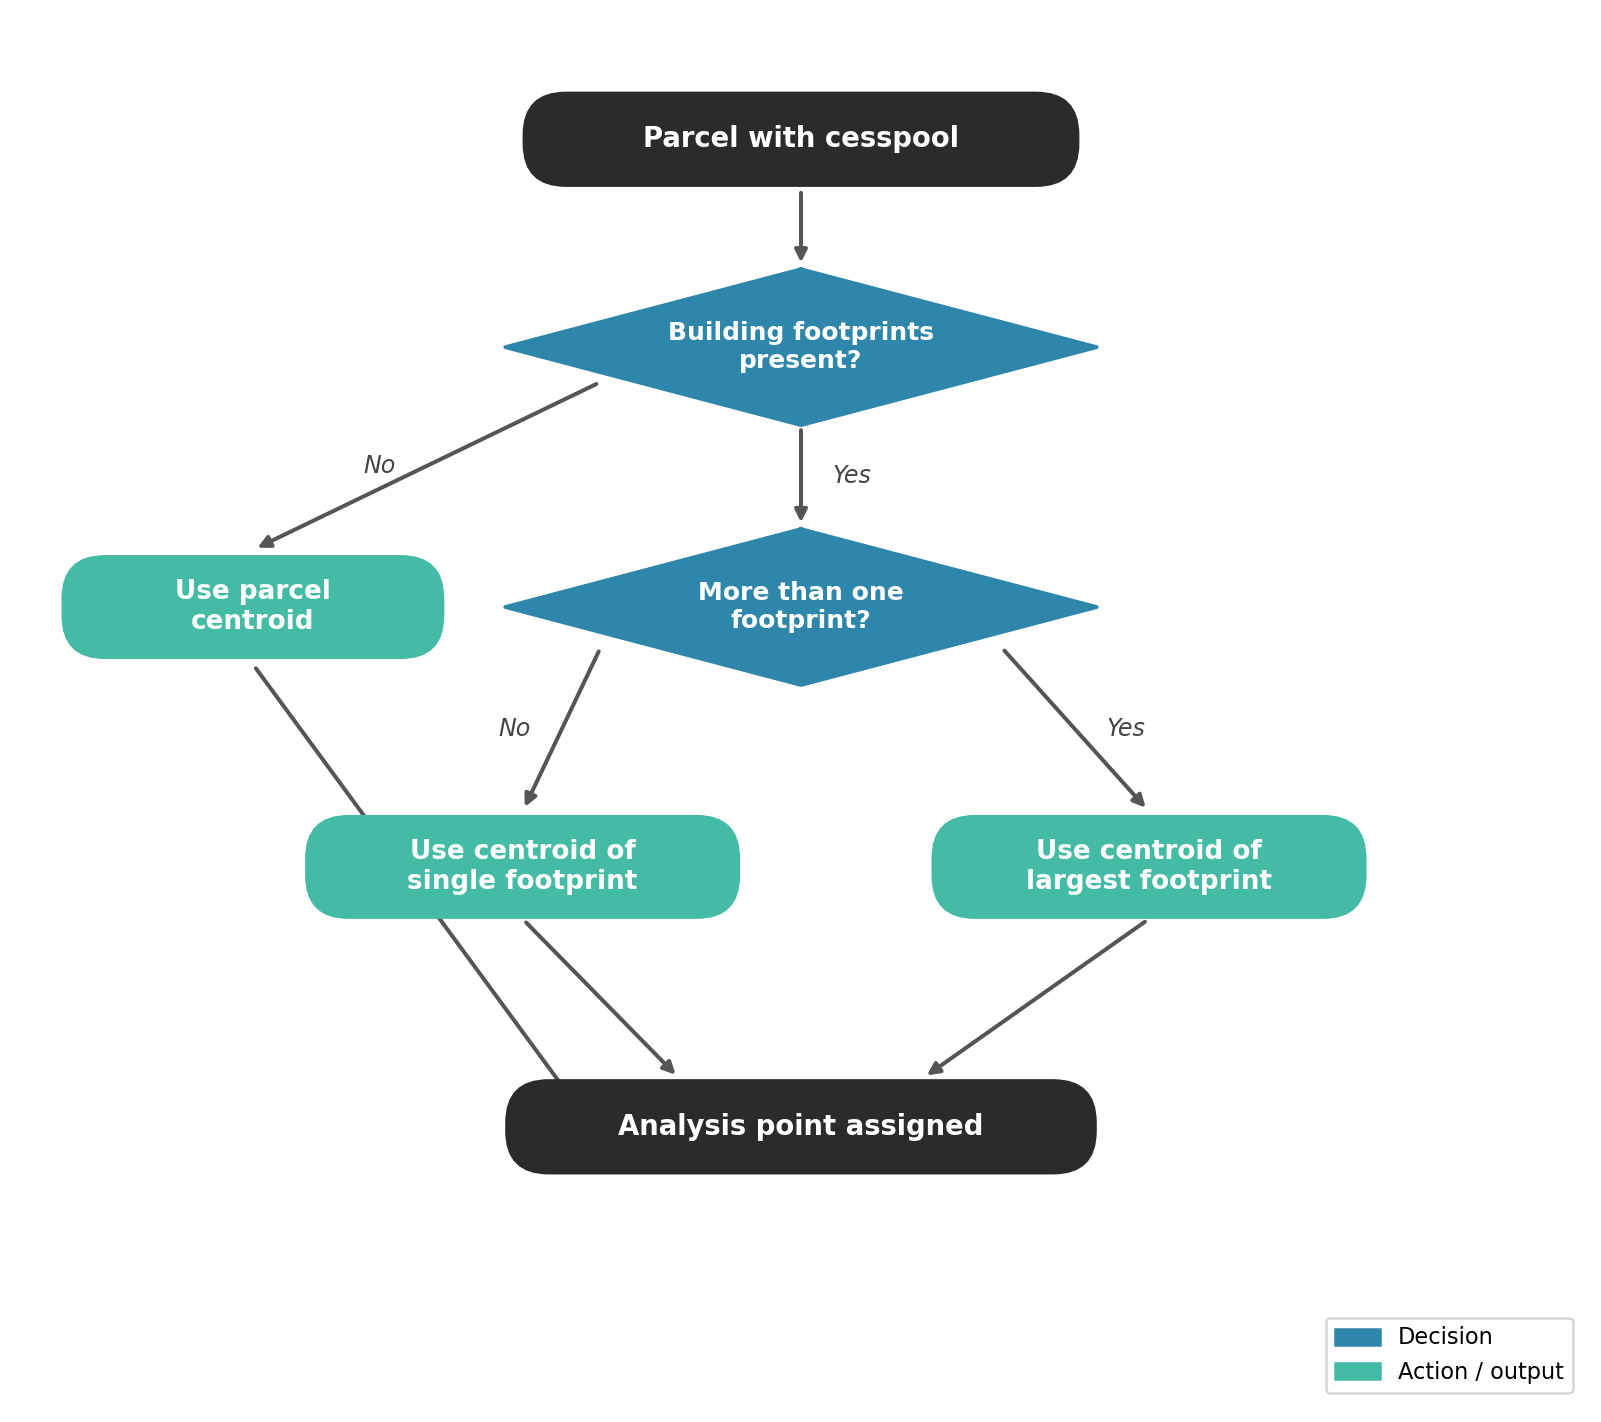{width="600px"}

In [ ]:
# Parcel analysis point source distribution

source_counts = (
    mpat_df["analysis_point_source"]
    .value_counts()
    .reset_index()
    .rename(columns={"analysis_point_source": "source", "count": "n"})
)

source_counts["label"] = source_counts["source"].map({
    "building_fp_largest_centroid": "Building Footprint Centroid",
    "parcel_centroid": "Parcel Centroid (Fallback)",
})

fig = go.Figure(
    go.Bar(
        x=source_counts["label"],
        y=source_counts["n"],
        marker_color=[COLORS["accent"], COLORS["qual"][2]],
        text=source_counts["n"].apply(lambda x: f"{x:,}"),
        textposition="outside",
    )
)

apply_theme(
    fig,
    title=dict(
        text="<b>Parcel Analysis Point Source</b>",
        x=0.5,
        xanchor="center",
        font=dict(size=18),
    ),
    xaxis_title="Source",
    yaxis_title="Number of Parcels",
    height=420,
)

fig.update_layout(showlegend=False, margin=dict(l=90, r=40, t=60, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, range=[0, source_counts["n"].max() * 1.12])
fig.show()

In [68]:
# Point source distribution by island (should be all Maui)

# Focus on Maui
m = Map(center=[MAUI_CENTER["lon"], MAUI_CENTER["lat"]], zoom=MAUI_ZOOM, height="550px")
m.add_basemap("CartoDB.Positron")

# Layer 1: MPAT parcel polygons
m.add_vector(
    mpat_gdf[["tmk", "geometry"]],
    name="Parcels with Cesspools",
    layer_type="fill",
    paint={
        "fill-color": "#6262627B",
        "fill-outline-color": "#d3d3d3",
    },
)

# Layer 2: Building footprint polygons per parcel
m.add_vector(
    building_fp_per_parcel_gdf[["tmk", "geometry"]],
    name="Building Footprints",
    layer_type="fill",
    paint={
        "fill-color": "#6B6B6BAE",
        "fill-outline-color": "#d3d3d3",
    },
)

# Layer 3: Building footprint centroid analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'building_fp_largest_centroid'"),
    name="Building Footprint Centroid (n=7,199)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["accent"],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

# Layer 4: Parcel centroid fallback analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'parcel_centroid'"),
    name="Parcel Centroid Fallback (n=306)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["qual"][2],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

m.add_layer_control(position="top-right")
m

MapLibreMap(center=[-156.3314, 20.7986], height='550px', style='https://basemaps.cartocdn.com/gl/positron-gl-s…

### Attributes (cesspools, bedrooms, building footprints)

In [14]:
# Bar chart
osds_counts = (
    mpat_df["osds_qty"]
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"osds_qty": "n_cesspools", "count": "n"})
)

fig = go.Figure(
    go.Bar(
        x=osds_counts["n_cesspools"].astype(str),
        y=osds_counts["n"],
        marker_color=COLORS["accent"],
        text=osds_counts["n"].apply(lambda x: f"{x:,}"),
        textposition="outside",
    )
)

apply_theme(
    fig,
    title=dict(text="<b>Cesspools per Parcel</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Number of Cesspools",
    yaxis_title="Number of Parcels",
    height=450,
)

fig.update_layout(showlegend=False, margin=dict(l=80, r=80, t=80, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, range=[0, osds_counts["n"].max() * 1.12])
fig.show()

In [15]:
# bedroom_qty bar chart

bedroom_counts = (
    mpat_df["bedroom_qty"]
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"bedroom_qty": "n_bedrooms", "count": "n"})
)

# Flag zeroes separately
colors = [
    COLORS["qual"][3] if v == 0 else COLORS["accent"]
    for v in bedroom_counts["n_bedrooms"]
]

fig = go.Figure(
    go.Bar(
        x=bedroom_counts["n_bedrooms"].astype(str),
        y=bedroom_counts["n"],
        marker_color=colors,
        text=bedroom_counts["n"].apply(lambda x: f"{x:,}"),
        textposition="outside",
    )
)

apply_theme(
    fig,
    title=dict(text="<b>Bedrooms per Parcel</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Number of Bedrooms",
    yaxis_title="Number of Parcels",
    height=450,
)

fig.update_layout(showlegend=False, margin=dict(l=80, r=80, t=80, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, range=[0, bedroom_counts["n"].max() * 1.12])

# Annotate the zero bar
fig.add_annotation(
    x="0",
    y=bedroom_counts.loc[bedroom_counts["n_bedrooms"] == 0, "n"].values[0],
    text="309 parcels with 0 bedrooms<br>non-residential or missing data",
    showarrow=True,
    arrowhead=2,
    ax=80,
    ay=-300,
    font=dict(size=11, color=COLORS["qual"][3]),
)

fig.show()

In [16]:
# Do cesspool counts scale with bedroom count as expected?

# ── bedroom_qty vs osds_qty — cross-tab heatmap ───────────────────────────────

# Cap axes at 95th percentile to avoid outliers compressing the main cluster
bedroom_cap = int(mpat_df["bedroom_qty"].quantile(0.95))
osds_cap    = int(mpat_df["osds_qty"].quantile(0.95))

crosstab = (
    mpat_df
    .loc[
        (mpat_df["bedroom_qty"] <= bedroom_cap) &
        (mpat_df["osds_qty"]    <= osds_cap)
    ]
    .groupby(["osds_qty", "bedroom_qty"])
    .size()
    .reset_index(name="n")
)

fig = go.Figure(
    go.Heatmap(
        x=crosstab["bedroom_qty"],
        y=crosstab["osds_qty"],
        z=crosstab["n"],
        colorscale=COLORS["seq"],
        hoverongaps=False,
        hovertemplate="Bedrooms: %{x}<br>Cesspools: %{y}<br>Parcels: %{z:,}<extra></extra>",
        colorbar=dict(title="Parcels"),
        xgap=2,
        ygap=2,
    )
)

apply_theme(
    fig,
    title=dict(text="<b>Bedrooms vs. Cesspools per Parcel</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Number of Bedrooms",
    yaxis_title="Number of Cesspools",
    height=420,
)

fig.update_layout(margin=dict(l=80, r=135, t=80, b=80))
fig.update_xaxes(showgrid=False, dtick=1)
fig.update_yaxes(showgrid=False, dtick=1)

fig.add_annotation(
    text=f"Capped at 95th percentile: bedrooms ≤ {bedroom_cap}, cesspools ≤ {osds_cap}",
    xref="paper", yref="paper",
    x=0, y=-0.17,
    showarrow=False,
    font=dict(size=10, color="#888888"),
    align="left",
)

fig.show()

In [17]:
# building_fp_qty bar chart

fp_counts = (
    mpat_df["building_fp_qty"]
    .dropna()
    .astype(int)
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"building_fp_qty": "n_footprints", "count": "n"})
)

fig = go.Figure(
    go.Bar(
        x=fp_counts["n_footprints"].astype(str),
        y=fp_counts["n"],
        marker_color=COLORS["accent"],
        text=fp_counts["n"].apply(lambda x: f"{x:,}"),
        textposition="outside",
    )
)

apply_theme(
    fig,
    title=dict(text="<b>Building Footprints per Parcel</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Number of Building Footprints",
    yaxis_title="Number of Parcels",
    height=450,
)

fig.update_layout(margin=dict(l=80, r=80, t=80, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, range=[0, fp_counts["n"].max() * 1.12])

fig.add_annotation(
    text="306 parcels with no building footprints not shown (structural nulls)",
    xref="paper", yref="paper",
    x=0, y=-0.12,
    showarrow=False,
    font=dict(size=10, color="#888888"),
    align="left",
)

fig.show()

In [18]:
# Do footprint-free parcels have more or fewer cesspools?

null_fp  = mpat_df.loc[mpat_df["building_fp_qty"].isnull(), "osds_qty"]
has_fp   = mpat_df.loc[mpat_df["building_fp_qty"].notna(), "osds_qty"]

fig = go.Figure()

for label, data, color in [
    ("No footprint (n=306)",    null_fp, COLORS["qual"][2]),
    ("Has footprint (n=7,199)", has_fp,  COLORS["accent"]),
]:
    fig.add_trace(go.Histogram(
        x=data,
        name=label,
        marker_color=color,
        opacity=0.75,
        histnorm="percent",
        nbinsx=13,
    ))

apply_theme(
    fig,
    title=dict(
        text="<b>Cesspool Count by Footprint Availability</b>",
        x=0.5, xanchor="center", font=dict(size=18)
    ),
    xaxis_title="Number of Cesspools",
    yaxis_title="% of Parcels (within group)",
    height=420,
)

fig.update_layout(
    barmode="overlay",
    margin=dict(l=80, r=80, t=80, b=60),
    legend=dict(x=0.72, y=0.95),
)
fig.update_xaxes(showgrid=False, dtick=1)
fig.update_yaxes(showgrid=False)
fig.show()

### Parcel and Building Areas

In [19]:
# Parcel area distribution with lot size threshold lines

# Thresholds in sq ft
T1 = 10_000
T2 = 21_000

fig = go.Figure(
    go.Histogram(
        x=np.log10(mpat_df["parcel_area_sqft"].dropna()),
        nbinsx=60,
        marker_color=COLORS["accent"],
        marker_line=dict(width=0.5, color="white"),
    )
)

# Threshold reference lines
for threshold, label, color, y_pos in [
    (T1, "10,000 sq ft", COLORS["qual"][3], 1.08),
    (T2, "21,000 sq ft", COLORS["qual"][2], 1.02),
]:
    fig.add_vline(
        x=np.log10(threshold),
        line=dict(color=color, width=1.5, dash="dash"),
    )
    fig.add_annotation(
        x=np.log10(threshold),
        y=y_pos,
        yref="paper",
        text=label,
        showarrow=False,
        font=dict(size=10, color=color),
        xanchor="center",
    )

apply_theme(
    fig,
    title=dict(text="<b>Parcel Area Distribution (log scale)</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Parcel Area (log₁₀ sq ft)",
    yaxis_title="Number of Parcels",
    height=450,
)

fig.update_layout(margin=dict(l=80, r=80, t=100, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [67]:
# Parcel area choropleth map

m = Map(center=[MAUI_CENTER["lon"], MAUI_CENTER["lat"]], zoom=MAUI_ZOOM, height="550px")
m.add_basemap("CartoDB.Positron")

m.add_vector(
    mpat_gdf[["tmk", "parcel_area_sqft", "geometry"]],
    name="Parcel Area (sq ft)",
    layer_type="fill",
    paint={
        "fill-color": [
            "interpolate", ["linear"],
            ["get", "parcel_area_sqft"],
            0,       "#f7fbff",
            10000,   "#c6dbef",
            21000,   "#6baed6",
            100000,  "#2171b5",
            500000,  "#08306b",
        ],
        "fill-opacity": 0.8,
        "fill-outline-color": "#d3d3d3",
    },
)

# Layer 2: Building footprint polygons per parcel
m.add_vector(
    building_fp_per_parcel_gdf[["tmk", "geometry"]],
    name="Building Footprints",
    layer_type="fill",
    paint={
        "fill-color": "#6B6B6BAE",
        "fill-outline-color": "#d3d3d3",
    },
)

# Layer 3: Building footprint centroid analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'building_fp_largest_centroid'"),
    name="Building Footprint Centroid (n=7,199)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["accent"],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

# Layer 4: Parcel centroid fallback analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'parcel_centroid'"),
    name="Parcel Centroid Fallback (n=306)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["qual"][2],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

m.add_layer_control(position="top-right")
m

MapLibreMap(center=[-156.3314, 20.7986], height='550px', style='https://basemaps.cartocdn.com/gl/positron-gl-s…

In [21]:
# Lot size requirement class bar chart

# Preserve logical order: small → medium → large
lot_order = [
    "Less than 10,000 sqft",
    "Between 10,000 and 21,000 sqft",
    "Greater than 21,000 sqft",
]

lot_counts = (
    mpat_df["lot_size_req"]
    .value_counts()
    .reindex(lot_order)
    .reset_index()
    .rename(columns={"lot_size_req": "category", "count": "n"})
)

lot_colors = [
    COLORS["ordered"]["low"],
    COLORS["ordered"]["medium"],
    COLORS["ordered"]["high"],
]

fig = go.Figure(
    go.Bar(
        x=lot_counts["category"],
        y=lot_counts["n"],
        marker_color=lot_colors,
        text=lot_counts["n"].apply(lambda x: f"{x:,}"),
        textposition="outside",
    )
)

apply_theme(
    fig,
    title=dict(text="<b>Lot Size Requirement Class</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Lot Size Class",
    yaxis_title="Number of Parcels",
    height=450,
)

fig.update_layout(margin=dict(l=80, r=80, t=80, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, range=[0, lot_counts["n"].max() * 1.12])
fig.show()

In [66]:
# Lot size requirement class choropleth map

# Map class labels to ordered colors
lot_color_map = {
    "Less than 10,000 sqft":          COLORS["ordered"]["low"],
    "Between 10,000 and 21,000 sqft": COLORS["ordered"]["medium"],
    "Greater than 21,000 sqft":       COLORS["ordered"]["high"],
}

mpat_gdf["lot_size_color"] = mpat_gdf["lot_size_req"].map(lot_color_map)

m = Map(center=[MAUI_CENTER["lon"], MAUI_CENTER["lat"]], zoom=MAUI_ZOOM, height="550px")
m.add_basemap("CartoDB.Positron")

m.add_vector(
    mpat_gdf[["tmk", "lot_size_req", "lot_size_color", "geometry"]],
    name="Lot Size Requirement Class",
    layer_type="fill",
    paint={
        "fill-color": ["get", "lot_size_color"],
        "fill-opacity": 0.8,
        "fill-outline-color": "#d3d3d3",
    },
)

# Layer 2: Building footprint polygons per parcel
m.add_vector(
    building_fp_per_parcel_gdf[["tmk", "geometry"]],
    name="Building Footprints",
    layer_type="fill",
    paint={
        "fill-color": "#6B6B6BAE",
        "fill-outline-color": "#d3d3d3",
    },
)

# Layer 3: Building footprint centroid analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'building_fp_largest_centroid'"),
    name="Building Footprint Centroid (n=7,199)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["accent"],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

# Layer 4: Parcel centroid fallback analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'parcel_centroid'"),
    name="Parcel Centroid Fallback (n=306)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["qual"][2],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

m.add_layer_control(position="top-right")
m

MapLibreMap(center=[-156.3314, 20.7986], height='550px', style='https://basemaps.cartocdn.com/gl/positron-gl-s…

In [23]:
# Building footprint total area distribution (log scale)

fig = go.Figure(
    go.Histogram(
        x=np.log10(mpat_df["building_fp_total_area_sqft"].dropna()),
        nbinsx=60,
        marker_color=COLORS["accent"],
        marker_line=dict(width=0.5, color="white"),
    )
)

apply_theme(
    fig,
    title=dict(text="<b>Building Footprint Total Area Distribution (log scale)</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Building Footprint Total Area (log₁₀ sq ft)",
    yaxis_title="Number of Parcels",
    height=420,
)

fig.update_layout(margin=dict(l=80, r=80, t=80, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [24]:
# Net parcel area distribution (log scale) with callout for negative values

n_negative = (mpat_df["net_parcel_area_sqft"] < 0).sum()
net_area_pos = mpat_df.loc[mpat_df["net_parcel_area_sqft"] > 0, "net_parcel_area_sqft"]

fig = go.Figure(
    go.Histogram(
        x=np.log10(net_area_pos),
        nbinsx=60,
        marker_color=COLORS["accent"],
        marker_line=dict(width=0.5, color="white"),
    )
)

apply_theme(
    fig,
    title=dict(text="<b>Net Parcel Area Distribution (log scale)</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Net Parcel Area (log₁₀ sq ft)",
    yaxis_title="Number of Parcels",
    height=420,
)

fig.update_layout(margin=dict(l=80, r=80, t=80, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.add_annotation(
    text=f"{n_negative} parcels excluded — negative net area (building footprint exceeds parcel area)",
    xref="paper", yref="paper",
    x=0, y=-0.11,
    showarrow=False,
    font=dict(size=10, color=COLORS["qual"][3]),
    align="left",
)

fig.show()

What happened with these 8 negative net areas?

In [25]:
# Building coverage ratio: building_fp_total_area_sqft / parcel_area_sqft

coverage_df = mpat_df.dropna(subset=["building_fp_total_area_sqft"]).copy()
coverage_df["coverage_ratio"] = (
    coverage_df["building_fp_total_area_sqft"] / coverage_df["parcel_area_sqft"]
).clip(upper=1.0)  # cap at 1 — the 8 negative net area parcels would exceed this

fig = go.Figure(
    go.Histogram(
        x=coverage_df["coverage_ratio"],
        nbinsx=50,
        marker_color=COLORS["accent"],
        marker_line=dict(width=0.5, color="white"),
    )
)

apply_theme(
    fig,
    title=dict(text="<b>Building Coverage Ratio</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Building Footprint Area / Parcel Area",
    yaxis_title="Number of Parcels",
    height=420,
)

fig.update_layout(margin=dict(l=80, r=80, t=80, b=60))
fig.update_xaxes(showgrid=False, tickformat=".0%")
fig.update_yaxes(showgrid=False)
fig.show()

### Distances

#### SMA

In [55]:
# Distance to SMA boundary histogram with threshold lines

fig = go.Figure(
    go.Histogram(
        x=mpat_df["dist_to_sma_ft"],
        nbinsx=60,
        marker_color=COLORS["accent"],
        marker_line=dict(width=0.5, color="white"),
    )
)

for threshold, label, color, y_pos in [
    (0,  "Within SMA", COLORS["accent"], 1.08),
    (50, "50 ft", COLORS["ordered"]["low"], 1.02),
]:
    fig.add_shape(
        type="line",
        x0=threshold, x1=threshold,
        y0=0, y1=1, yref="paper",
        line=dict(color=color, width=2, dash="dash"),
        layer="above",
    )
    fig.add_annotation(
        x=threshold, y=y_pos, yref="paper",
        text=label,
        showarrow=False,
        font=dict(size=10, color=color),
        xanchor="center",
    )

apply_theme(
    fig,
    title=dict(text="<b>Distance to Special Management Area (SMA)</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Distance to SMA (ft)",
    yaxis_title="Number of Parcels",
    height=450,
)

fig.update_layout(margin=dict(l=80, r=80, t=100, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [27]:
# SMA overlap and proximity class bar charts

fig = make_subplots(rows=1, cols=2, subplot_titles=["SMA Parcel Overlap", "SMA Proximity Class"])

# in_sma
sma_flag = mpat_df["in_sma"].value_counts().sort_index().reset_index()
sma_flag["label"] = sma_flag["in_sma"].map({0: "Outside SMA", 1: "Within SMA"})

fig.add_trace(
    go.Bar(
        x=sma_flag["label"],
        y=sma_flag["count"],
        marker_color=[COLORS["binary"][0], COLORS["binary"][1]],
        text=sma_flag["count"].apply(lambda x: f"{x:,}"),
        textposition="outside",
        showlegend=False,
    ),
    row=1, col=1,
)

# sma_constraints
sma_order = ["Within 50 ft", "Beyond 50 ft"]
sma_class = (
    mpat_df["sma_constraints"]
    .value_counts()
    .reindex(sma_order)
    .reset_index()
    .rename(columns={"sma_constraints": "category", "count": "n"})
)

fig.add_trace(
    go.Bar(
        x=sma_class["category"],
        y=sma_class["n"],
        marker_color=[COLORS["ordered"]["low"], COLORS["ordered"]["high"]],
        text=sma_class["n"].apply(lambda x: f"{x:,}"),
        textposition="outside",
        showlegend=False,
    ),
    row=1, col=2,
)

fig.update_layout(
    **make_layout(t=90, b=60, l=80, r=80),
    title=make_title(
        "Special Management Area Constraints",
        "",
        y=0.9,
    ),
    height=420,
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(
    showgrid=False,
    range=[0, max(sma_flag["count"].max(), sma_class["n"].max()) * 1.15],
)
fig.show()

In [65]:
# SMA proximity class choropleth map

sma_color_map = {
    "Within 50 ft": COLORS["ordered"]["low"],
    "Beyond 50 ft": COLORS["ordered"]["high"],
}
mpat_gdf["sma_color"] = mpat_gdf["sma_constraints"].map(sma_color_map)

m = Map(center=[MAUI_CENTER["lon"], MAUI_CENTER["lat"]], zoom=MAUI_ZOOM, height="550px")
m.add_basemap("CartoDB.Positron")

# Layer 1: all parcels filled by SMA proximity class
m.add_vector(
    mpat_gdf[["tmk", "sma_constraints", "sma_color", "geometry"]],
    name="SMA Proximity Class",
    layer_type="fill",
    paint={
        "fill-color": ["get", "sma_color"],
        "fill-opacity": 0.8,
        "fill-outline-color": "#d3d3d3",
    },
)

# SMA
m.add_vector(
    sma_gdf[["geometry"]],
    name="Special Management Area",
    layer_type="fill",
    paint={
        "fill-color": "#C73E1D",
        "fill-opacity": 0.2,
        "fill-outline-color": "#C73E1D",
    },
)

# in_sma parcels — outline only in accent blue
m.add_vector(
    mpat_gdf.loc[mpat_gdf["in_sma"] == 1, ["tmk", "geometry"]],
    name="Within SMA (n=931)",
    layer_type="line",
    paint={
        "line-color": COLORS["accent"],
        "line-width": 2.5,
    },
)

# Building footprint polygons per parcel
m.add_vector(
    building_fp_per_parcel_gdf[["tmk", "geometry"]],
    name="Building Footprints",
    layer_type="fill",
    paint={
        "fill-color": "#6B6B6BAE",
        "fill-outline-color": "#d3d3d3",
    },
)

# Building footprint centroid analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'building_fp_largest_centroid'"),
    name="Building Footprint Centroid (n=7,199)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["accent"],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

# Parcel centroid fallback analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'parcel_centroid'"),
    name="Parcel Centroid Fallback (n=306)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["qual"][2],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

m.add_layer_control(position="top-right")
m

MapLibreMap(center=[-156.3314, 20.7986], height='550px', style='https://basemaps.cartocdn.com/gl/positron-gl-s…

#### Flood Zones

In [29]:
# In flood zone bar chart

flood_flag = mpat_df["in_flood_zone"].value_counts().sort_index().reset_index()
flood_flag["label"] = flood_flag["in_flood_zone"].map({
    0: "Outside Flood Zone",
    1: "Within Flood Zone",
})

fig = go.Figure(
    go.Bar(
        x=flood_flag["label"],
        y=flood_flag["count"],
        marker_color=[COLORS["binary"][0], COLORS["binary"][1]],
        text=flood_flag["count"].apply(lambda x: f"{x:,}"),
        textposition="outside",
    )
)

apply_theme(
    fig,
    title=dict(text="<b>FEMA Flood Zone Flag</b>", x=0.5, xanchor="center", font=dict(size=18), y=0.9),
    xaxis_title="Flood Zone Status",
    yaxis_title="Number of Parcels",
    height=420,
)

fig.update_layout(margin=dict(l=100, r=60, t=70, b=80))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, range=[0, flood_flag["count"].max() * 1.15])
fig.show()

In [64]:
# In flood zone choropleth map

flood_zones_gdf = flood_zones_gdf.query("sfha_tf == 'T'")

flood_color_map = {
    0: COLORS["binary"][0],
    1: COLORS["binary"][1],
}
mpat_gdf["flood_color"] = mpat_gdf["in_flood_zone"].map(flood_color_map)

m = Map(center=[MAUI_CENTER["lon"], MAUI_CENTER["lat"]], zoom=MAUI_ZOOM, height="550px")
m.add_basemap("CartoDB.Positron")

m.add_vector(
    mpat_gdf[["tmk", "in_flood_zone", "flood_color", "geometry"]],
    name="FEMA Flood Zone",
    layer_type="fill",
    paint={
        "fill-color": ["get", "flood_color"],
        "fill-opacity": 0.8,
        "fill-outline-color": "#d3d3d3",
    },
)

# Flood zones
m.add_vector(
    flood_zones_gdf[["geometry"]],
    name="Flood Zones",
    layer_type="fill",
    paint={
        "fill-color": COLORS["qual"][3],
        "fill-opacity": 0.2,
        "fill-outline-color": COLORS["qual"][3],
    },
)

# Layer 2: Building footprint polygons per parcel
m.add_vector(
    building_fp_per_parcel_gdf[["tmk", "geometry"]],
    name="Building Footprints",
    layer_type="fill",
    paint={
        "fill-color": "#6B6B6BAE",
        "fill-outline-color": "#d3d3d3",
    },
)

# Layer 3: Building footprint centroid analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'building_fp_largest_centroid'"),
    name="Building Footprint Centroid (n=7,199)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["accent"],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

# Layer 4: Parcel centroid fallback analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'parcel_centroid'"),
    name="Parcel Centroid Fallback (n=306)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["qual"][2],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

m.add_layer_control(position="top-right")
m

MapLibreMap(center=[-156.3314, 20.7986], height='550px', style='https://basemaps.cartocdn.com/gl/positron-gl-s…

#### Coastline

In [31]:
# Distance to coast histogram with 100 ft threshold line

fig = go.Figure(
    go.Histogram(
        x=mpat_df["dist_to_coast_ft"],
        nbinsx=60,
        marker_color=COLORS["accent"],
        marker_line=dict(width=0.5, color="white"),
    )
)

fig.add_shape(
    type="line",
    x0=100, x1=100,
    y0=0, y1=1, yref="paper",
    line=dict(color=COLORS["qual"][3], width=2, dash="dash"),
    layer="above",
)
fig.add_annotation(
    x=100, y=1.05, yref="paper",
    text="100 ft",
    showarrow=False,
    font=dict(size=10, color=COLORS["qual"][3]),
    xanchor="center",
)

apply_theme(
    fig,
    title=dict(text="<b>Distance to Coastline</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Distance to Coast (ft)",
    yaxis_title="Number of Parcels",
    height=450,
)

fig.update_layout(margin=dict(l=80, r=80, t=100, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [32]:
# Coastal proximity flag bar chart

coast_flag = mpat_df["coast_within_100_ft"].value_counts().sort_index().reset_index()
coast_flag["label"] = coast_flag["coast_within_100_ft"].map({
    0: "Beyond 100 ft",
    1: "Within 100 ft",
})

fig = go.Figure(
    go.Bar(
        x=coast_flag["label"],
        y=coast_flag["count"],
        marker_color=[COLORS["binary"][0], COLORS["binary"][1]],
        text=coast_flag["count"].apply(lambda x: f"{x:,}"),
        textposition="outside",
    )
)

apply_theme(
    fig,
    title=dict(text="<b>Coastal Proximity Flag</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Coastal Proximity",
    yaxis_title="Number of Parcels",
    height=420,
)

fig.update_layout(margin=dict(l=80, r=80, t=80, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, range=[0, coast_flag["count"].max() * 1.15])
fig.show()

In [33]:
mpat_df.loc[mpat_df["coast_within_100_ft"] == 1, ["tmk", "dist_to_coast_ft"]].sort_values("dist_to_coast_ft")

,tmk,dist_to_coast_ft
6917,236001032,20.811703
230,214008003,30.210863
6918,236001035,57.574878
6624,233001004,68.388210
123,213007022,81.278683
7250,245013007,87.267410
7100,243007024,89.270554
7252,245013025,90.794829
11,211003068,94.094246
7249,245013006,96.167829


In [63]:
# Distance to coast choropleth map with 95th percentile cap to handle outliers

coast_cap = mpat_gdf["dist_to_coast_ft"].quantile(0.95)
mpat_gdf["coast_dist_capped"] = mpat_gdf["dist_to_coast_ft"].clip(upper=coast_cap)
coastline_gdf = coastline_gdf.query("isle == 'Maui'")
coastline_gdf["geometry"] = coastline_gdf.geometry.boundary

m = Map(center=[MAUI_CENTER["lon"], MAUI_CENTER["lat"]], zoom=MAUI_ZOOM, height="550px")
m.add_basemap("CartoDB.Positron")

m.add_vector(
    mpat_gdf[["tmk", "dist_to_coast_ft", "coast_dist_capped", "geometry"]],
    name="Distance to Coast (ft)",
    layer_type="fill",
    paint={
        "fill-color": [
            "interpolate", ["linear"],
            ["get", "coast_dist_capped"],
            0,                    "#08306b",
            coast_cap * 0.25,    "#2171b5",
            coast_cap * 0.50,    "#6baed6",
            coast_cap * 0.75,    "#c6dbef",
            coast_cap,           "#f7fbff",
        ],
        "fill-opacity": 0.8,
        "fill-outline-color": "#d3d3d3",
    },
)

# Add coastline
m.add_vector(
    coastline_gdf[["geometry"]],
    name="Coastline",
    layer_type="line",
    paint={"line-color": COLORS["qual"][3], "line-width": 1.5},
)

# Layer 2: Building footprint polygons per parcel
m.add_vector(
    building_fp_per_parcel_gdf[["tmk", "geometry"]],
    name="Building Footprints",
    layer_type="fill",
    paint={
        "fill-color": "#6B6B6BAE",
        "fill-outline-color": "#d3d3d3",
    },
)

# Layer 3: Building footprint centroid analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'building_fp_largest_centroid'"),
    name="Building Footprint Centroid (n=7,199)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["accent"],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

# Layer 4: Parcel centroid fallback analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'parcel_centroid'"),
    name="Parcel Centroid Fallback (n=306)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["qual"][2],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

m.add_layer_control(position="top-right")
m

MapLibreMap(center=[-156.3314, 20.7986], height='550px', style='https://basemaps.cartocdn.com/gl/positron-gl-s…

#### Streams

In [57]:
# Stream proximity histogram with 50 ft threshold line

fig = go.Figure(
    go.Histogram(
        x=mpat_df["dist_to_streams_ft"],
        nbinsx=60,
        marker_color=COLORS["accent"],
        marker_line=dict(width=0.5, color="white"),
    )
)

fig.add_shape(
    type="line",
    x0=50, x1=50,
    y0=0, y1=1, yref="paper",
    line=dict(color=COLORS["qual"][3], width=2, dash="dash"),
    layer="above",
)
fig.add_annotation(
    x=50, y=1.05, yref="paper",
    text="50 ft",
    showarrow=False,
    font=dict(size=10, color=COLORS["qual"][3]),
    xanchor="center",
)

apply_theme(
    fig,
    title=dict(text="<b>Distance to Nearest Stream</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Distance to Stream (ft)",
    yaxis_title="Number of Parcels",
    height=450,
)

fig.update_layout(margin=dict(l=80, r=80, t=100, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [36]:
# Stream proximity flag bar chart

stream_flag = mpat_df["stream_within_50_ft"].value_counts().sort_index().reset_index()
stream_flag["label"] = stream_flag["stream_within_50_ft"].map({
    0: "Beyond 50 ft",
    1: "Within 50 ft",
})

fig = go.Figure(
    go.Bar(
        x=stream_flag["label"],
        y=stream_flag["count"],
        marker_color=[COLORS["binary"][0], COLORS["binary"][1]],
        text=stream_flag["count"].apply(lambda x: f"{x:,}"),
        textposition="outside",
    )
)

apply_theme(
    fig,
    title=dict(text="<b>Stream Proximity Flag</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Stream Proximity",
    yaxis_title="Number of Parcels",
    height=420,
)

fig.update_layout(margin=dict(l=80, r=80, t=80, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, range=[0, stream_flag["count"].max() * 1.15])
fig.show()

In [37]:
# Distance to stream choropleth map with 95th percentile cap to handle outliers

stream_cap = mpat_gdf["dist_to_streams_ft"].quantile(0.95)
mpat_gdf["stream_dist_capped"] = mpat_gdf["dist_to_streams_ft"].clip(upper=stream_cap)

m = Map(center=[MAUI_CENTER["lon"], MAUI_CENTER["lat"]], zoom=MAUI_ZOOM, height="550px")
m.add_basemap("CartoDB.Positron")

m.add_vector(
    mpat_gdf[["tmk", "dist_to_streams_ft", "stream_dist_capped", "geometry"]],
    name="Distance to Stream (ft)",
    layer_type="fill",
    paint={
        "fill-color": [
            "interpolate", ["linear"],
            ["get", "stream_dist_capped"],
            0,                     "#08306b",
            stream_cap * 0.25,    "#2171b5",
            stream_cap * 0.50,    "#6baed6",
            stream_cap * 0.75,    "#c6dbef",
            stream_cap,           "#f7fbff",
        ],
        "fill-opacity": 0.8,
        "fill-outline-color": "#d3d3d3",
    },
)

# Streams
m.add_vector(
    streams_gdf[["geometry"]],
    name="Streams",
    layer_type="line",
    paint={
        "line-color": "#2E86AB",
        "line-width": 1.5,
        "line-opacity": 0.6,
    },
)

# Layer 2: Building footprint polygons per parcel
m.add_vector(
    building_fp_per_parcel_gdf[["tmk", "geometry"]],
    name="Building Footprints",
    layer_type="fill",
    paint={
        "fill-color": "#6B6B6BAE",
        "fill-outline-color": "#d3d3d3",
    },
)

# Layer 3: Building footprint centroid analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'building_fp_largest_centroid'"),
    name="Building Footprint Centroid (n=7,199)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["accent"],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

# Layer 4: Parcel centroid fallback analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'parcel_centroid'"),
    name="Parcel Centroid Fallback (n=306)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["qual"][2],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

m.add_layer_control(position="top-right")
m

MapLibreMap(center=[-156.3314, 20.7986], height='550px', style='https://basemaps.cartocdn.com/gl/positron-gl-s…

#### Wells

In [38]:
# Distance to nearest domestic and municipal wells histograms

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Distance to Nearest Domestic Well", "Distance to Nearest Municipal Well"],
)

for col, color, col_num in [
    ("dist_to_dom_well_ft", COLORS["accent"],   1),
    ("dist_to_mun_well_ft", COLORS["qual"][0],  2),
]:
    fig.add_trace(
        go.Histogram(
            x=mpat_df[col],
            nbinsx=60,
            marker_color=color,
            marker_line=dict(width=0.5, color="white"),
            showlegend=False,
        ),
        row=1, col=col_num,
    )

fig.update_layout(
    **make_layout(t=90, b=60, l=110, r=0),
    title=make_title(
        "Distance to Nearest Domestic and Municipal Wells",
        "",
        y=0.9,
    ),
    height=420,
)
fig.update_xaxes(showgrid=False, title_text="Distance (ft)")
fig.update_yaxes(showgrid=False, title_text="Number of Parcels", col=1)
fig.show()

In [39]:
# Distance to domestic well choropleth map with 95th percentile cap to handle outliers

dom_cap = mpat_gdf["dist_to_dom_well_ft"].quantile(0.95)
mpat_gdf["dom_well_capped"] = mpat_gdf["dist_to_dom_well_ft"].clip(upper=dom_cap)

m = Map(center=[MAUI_CENTER["lon"], MAUI_CENTER["lat"]], zoom=MAUI_ZOOM, height="550px")
m.add_basemap("CartoDB.Positron")

m.add_vector(
    mpat_gdf[["tmk", "dist_to_dom_well_ft", "dom_well_capped", "geometry"]],
    name="Distance to Domestic Well (ft)",
    layer_type="fill",
    paint={
        "fill-color": [
            "interpolate", ["linear"],
            ["get", "dom_well_capped"],
            0,             "#08306b",
            dom_cap * 0.25, "#2171b5",
            dom_cap * 0.50, "#6baed6",
            dom_cap * 0.75, "#c6dbef",
            dom_cap,        "#f7fbff",
        ],
        "fill-opacity": 0.8,
        "fill-outline-color": "#d3d3d3",
    },
)

# Domestic wells
m.add_vector(
    wells_dom_gdf[["geometry"]],
    name="Domestic Wells (n=95)",
    layer_type="circle",
    paint={
        "circle-radius": 4,
        "circle-color": COLORS["qual"][3],
        "circle-stroke-color": "white",
        "circle-stroke-width": 1,
    },
)

# Layer 2: Building footprint polygons per parcel
m.add_vector(
    building_fp_per_parcel_gdf[["tmk", "geometry"]],
    name="Building Footprints",
    layer_type="fill",
    paint={
        "fill-color": "#6B6B6BAE",
        "fill-outline-color": "#d3d3d3",
    },
)

# Layer 3: Building footprint centroid analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'building_fp_largest_centroid'"),
    name="Building Footprint Centroid (n=7,199)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["accent"],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

# Layer 4: Parcel centroid fallback analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'parcel_centroid'"),
    name="Parcel Centroid Fallback (n=306)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["qual"][2],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

m.add_layer_control(position="top-right")
m

MapLibreMap(center=[-156.3314, 20.7986], height='550px', style='https://basemaps.cartocdn.com/gl/positron-gl-s…

In [40]:
# Distance to municipal well choropleth map with 95th percentile cap to handle outliers

mun_cap = mpat_gdf["dist_to_mun_well_ft"].quantile(0.95)
mpat_gdf["mun_well_capped"] = mpat_gdf["dist_to_mun_well_ft"].clip(upper=mun_cap)

m = Map(center=[MAUI_CENTER["lon"], MAUI_CENTER["lat"]], zoom=MAUI_ZOOM, height="550px")
m.add_basemap("CartoDB.Positron")

m.add_vector(
    mpat_gdf[["tmk", "dist_to_mun_well_ft", "mun_well_capped", "geometry"]],
    name="Distance to Municipal Well (ft)",
    layer_type="fill",
    paint={
        "fill-color": [
            "interpolate", ["linear"],
            ["get", "mun_well_capped"],
            0,             "#08306b",
            mun_cap * 0.25, "#2171b5",
            mun_cap * 0.50, "#6baed6",
            mun_cap * 0.75, "#c6dbef",
            mun_cap,        "#f7fbff",
        ],
        "fill-opacity": 0.8,
        "fill-outline-color": "#d3d3d3",
    },
)

# Municipal wells
m.add_vector(
    wells_mun_gdf[["geometry"]],
    name="Municipal Wells (n=81)",
    layer_type="circle",
    paint={
        "circle-radius": 4,
        "circle-color": COLORS["qual"][3],
        "circle-stroke-color": "white",
        "circle-stroke-width": 1,
    },
)

# Layer 2: Building footprint polygons per parcel
m.add_vector(
    building_fp_per_parcel_gdf[["tmk", "geometry"]],
    name="Building Footprints",
    layer_type="fill",
    paint={
        "fill-color": "#6B6B6BAE",
        "fill-outline-color": "#d3d3d3",
    },
)

# Layer 3: Building footprint centroid analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'building_fp_largest_centroid'"),
    name="Building Footprint Centroid (n=7,199)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["accent"],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

# Layer 4: Parcel centroid fallback analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'parcel_centroid'"),
    name="Parcel Centroid Fallback (n=306)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["qual"][2],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

m.add_layer_control(position="top-right")
m

MapLibreMap(center=[-156.3314, 20.7986], height='550px', style='https://basemaps.cartocdn.com/gl/positron-gl-s…

In [41]:
# Box plots comparing distance variables

dist_cols = [
    "dist_to_sma_ft",
    "dist_to_coast_ft",
    "dist_to_streams_ft",
    "dist_to_dom_well_ft",
    "dist_to_mun_well_ft",
]

dist_labels = {
    "dist_to_sma_ft":      "To SMA",
    "dist_to_coast_ft":    "To Coast",
    "dist_to_streams_ft":  "To Streams",
    "dist_to_dom_well_ft": "To Domestic Well",
    "dist_to_mun_well_ft": "To Municipal Well",
}

fig = go.Figure()

for i, col in enumerate(dist_cols):
    fig.add_trace(
        go.Box(
            y=mpat_df[col].dropna(),
            name=dist_labels[col],
            marker_color=COLORS["qual"][i % len(COLORS["qual"])],
            boxmean=True,  # show mean as dashed line
            showlegend=False,
        )
    )

apply_theme(
    fig,
    title=dict(
        text="<b>Distance Variables — Distributional Comparison</b>",
        x=0.5, xanchor="center", font=dict(size=18),
    ),
    xaxis_title="Distance Variable",
    yaxis_title="Distance (ft)",
    height=500,
)

fig.update_layout(margin=dict(l=80, r=40, t=100, b=80))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.add_annotation(
    text="Whiskers extend to 1.5× IQR | Dashed line shows mean",
    xref="paper", yref="paper",
    x=0, y=-0.15,
    showarrow=False,
    font=dict(size=10, color="#888888"),
    align="left",
)

fig.show()

### Environmental

#### Soils

In [ ]:
# ksat histograms for high, low, and representative values with note about 3 parcels outside NRCS soils extent excluded

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=[
        "Hydraulic Conductivity (High)",
        "Hydraulic Conductivity (Low)",
        "Hydraulic Conductivity (Representative)",
    ],
)

for col, col_num in [
    ("ksat_h", 1),
    ("ksat_l", 2),
    ("ksat_r", 3),
]:
    fig.add_trace(
        go.Histogram(
            x=mpat_df[col].dropna(),
            nbinsx=50,
            marker_color=COLORS["accent"],
            marker_line=dict(width=0.5, color="white"),
            showlegend=False,
        ),
        row=1, col=col_num,
    )

fig.update_layout(
    **make_layout(t=80, b=80, l=100, r=80),
    title=make_title(
        "Soil Hydraulic Conductivity (Ksat)",
        "",
        y=0.9,
    ),
    height=410,
)
fig.update_xaxes(showgrid=False, title_text="Ksat (source units)")
fig.update_yaxes(showgrid=False, title_text="Number of Parcels", col=1)

fig.add_annotation(
    text="3 parcels outside NRCS soils extent excluded",
    xref="paper", yref="paper",
    x=0, y=-0.275,
    showarrow=False,
    font=dict(size=10, color="#888888"),
    align="left",
)

fig.show()

In [43]:
# ksat_r is the representative value used for suitability screening

ksat_r = mpat_df["ksat_r"].dropna()
print(f"ksat_r  n={len(ksat_r):,}  min={ksat_r.min():.2f}  "
      f"median={ksat_r.median():.2f}  mean={ksat_r.mean():.2f}  "
      f"max={ksat_r.max():.2f}  std={ksat_r.std():.2f}")

ksat_r  n=7,502  min=0.22  median=10.77  mean=28.96  max=398.50  std=39.65


In [44]:
# ksat_r choropleth map with 95th percentile cap to handle outliers

ksat_cap = mpat_gdf["ksat_r"].quantile(0.95)
mpat_gdf["ksat_r_capped"] = mpat_gdf["ksat_r"].clip(upper=ksat_cap)

m = Map(center=[MAUI_CENTER["lon"], MAUI_CENTER["lat"]], zoom=MAUI_ZOOM, height="550px")
m.add_basemap("CartoDB.Positron")

m.add_vector(
    mpat_gdf[["tmk", "ksat_r", "ksat_r_capped", "geometry"]],
    name="Ksat Representative",
    layer_type="fill",
    paint={
        "fill-color": [
            "interpolate", ["linear"],
            ["get", "ksat_r_capped"],
            0,              "#f7fbff",
            ksat_cap * 0.25, "#c6dbef",
            ksat_cap * 0.50, "#6baed6",
            ksat_cap * 0.75, "#2171b5",
            ksat_cap,        "#08306b",
        ],
        "fill-opacity": 0.8,
        "fill-outline-color": "#d3d3d3",
    },
)

# Layer 2: Building footprint polygons per parcel
m.add_vector(
    building_fp_per_parcel_gdf[["tmk", "geometry"]],
    name="Building Footprints",
    layer_type="fill",
    paint={
        "fill-color": "#6B6B6BAE",
        "fill-outline-color": "#d3d3d3",
    },
)

# Layer 3: Building footprint centroid analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'building_fp_largest_centroid'"),
    name="Building Footprint Centroid (n=7,199)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["accent"],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

# Layer 4: Parcel centroid fallback analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'parcel_centroid'"),
    name="Parcel Centroid Fallback (n=306)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": COLORS["qual"][2],
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

m.add_layer_control(position="top-right")
m

MapLibreMap(center=[-156.3314, 20.7986], height='550px', style='https://basemaps.cartocdn.com/gl/positron-gl-s…

#### Hydrology

In [45]:
# Average annual rainfall histogram with xeric/mesic and mesic/hydric threshold lines

fig = go.Figure(
    go.Histogram(
        x=mpat_df["avg_rainfall_in"].dropna(),
        nbinsx=60,
        marker_color=COLORS["accent"],
        marker_line=dict(width=0.5, color="white"),
    )
)

for threshold, label, color, y_pos in [
    (20,  "20 in (Xeric/Mesic)",  COLORS["qual"][3], 1.08),
    (75,  "75 in (Mesic/Hydric)", COLORS["qual"][2], 1.02),
]:
    fig.add_shape(
        type="line",
        x0=threshold, x1=threshold,
        y0=0, y1=1, yref="paper",
        line=dict(color=color, width=2, dash="dash"),
        layer="above",
    )
    fig.add_annotation(
        x=threshold, y=y_pos, yref="paper",
        text=label,
        showarrow=False,
        font=dict(size=10, color=color),
        xanchor="center",
    )

apply_theme(
    fig,
    title=dict(text="<b>Average Annual Rainfall</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Average Rainfall (in)",
    yaxis_title="Number of Parcels",
    height=450,
)

fig.update_layout(margin=dict(l=80, r=80, t=100, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [59]:
# Climate suitability class bar chart

climate_order = ["Xeric", "Mesic", "Hydric"]

climate_counts = (
    mpat_df["climate_suitability"]
    .value_counts()
    .reindex(climate_order)
    .reset_index()
    .rename(columns={"climate_suitability": "category", "count": "n"})
)

fig = go.Figure(
    go.Bar(
        x=climate_counts["category"],
        y=climate_counts["n"],
        marker_color=[
            COLORS["ordered"]["low"],
            COLORS["ordered"]["medium"],
            COLORS["ordered"]["high"],
        ],
        text=climate_counts["n"].apply(lambda x: f"{x:,}"),
        textposition="outside",
    )
)

apply_theme(
    fig,
    title=dict(text="<b>Climate Suitability Classes</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Climate Class",
    yaxis_title="Number of Parcels",
    height=450,
)

fig.update_layout(margin=dict(l=80, r=80, t=80, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, range=[0, climate_counts["n"].max() * 1.15])
fig.show()

In [47]:
# Climate suitability choropleth map with average rainfall fill and climate class outline

climate_stroke_map = {
    "Xeric":  COLORS["ordered"]["low"],
    "Mesic":  COLORS["ordered"]["medium"],
    "Hydric": COLORS["ordered"]["high"],
}

mpat_gdf["climate_stroke"] = mpat_gdf["climate_suitability"].map(climate_stroke_map)

m = Map(center=[MAUI_CENTER["lon"], MAUI_CENTER["lat"]], zoom=MAUI_ZOOM, height="550px")
m.add_basemap("CartoDB.Positron")

# Fill by continuous rainfall value
m.add_vector(
    mpat_gdf[["tmk", "avg_rainfall_in", "geometry"]],
    name="Average Annual Rainfall (in)",
    layer_type="fill",
    paint={
        "fill-color": [
            "interpolate", ["linear"],
            ["get", "avg_rainfall_in"],
            0,   "#f7fbff",
            20,  "#c6dbef",
            75,  "#6baed6",
            150, "#2171b5",
            209, "#08306b",
        ],
        "fill-opacity": 0.8,
        "fill-outline-color": "transparent",
    },
)

# Outline by climate suitability class
m.add_vector(
    mpat_gdf[["tmk", "climate_suitability", "climate_stroke", "geometry"]],
    name="Climate Suitability Class (outline)",
    layer_type="line",
    paint={
        "line-color": ["get", "climate_stroke"],
        "line-width": 2.5,
    },
)

# Building footprint polygons per parcel
m.add_vector(
    building_fp_per_parcel_gdf[["tmk", "geometry"]],
    name="Building Footprints",
    layer_type="fill",
    paint={
        "fill-color": "#6B6B6BAE",
        "fill-outline-color": "#d3d3d3",
    },
)

# Building footprint centroid analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'building_fp_largest_centroid'"),
    name="Building Footprint Centroid (n=7,199)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": "#B7B5B5AF",
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

# Layer 4: Parcel centroid fallback analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'parcel_centroid'"),
    name="Parcel Centroid Fallback (n=306)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": "#B7B5B5AF",
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

m.add_layer_control(position="top-right")
m

MapLibreMap(center=[-156.3314, 20.7986], height='550px', style='https://basemaps.cartocdn.com/gl/positron-gl-s…

For west Maui only:

In [48]:
# Depth to water table histogram with 3 ft and 6 ft threshold lines

p99 = mpat_df["depth_to_wt_ft"].quantile(0.99)

fig = go.Figure(
    go.Histogram(
        x=mpat_df["depth_to_wt_ft"].dropna().clip(upper=p99),
        nbinsx=60,
        marker_color=COLORS["accent"],
        marker_line=dict(width=0.5, color="white"),
    )
)

for threshold, label, color, y_pos in [
    (3, "3 ft", COLORS["ordered"]["low"],  1.08),
    (6, "6 ft", COLORS["ordered"]["high"], 1.02),
]:
    fig.add_shape(
        type="line",
        x0=threshold, x1=threshold,
        y0=0, y1=1, yref="paper",
        line=dict(color=color, width=2.5, dash="dash"),
        layer="above",
    )
    fig.add_annotation(
        x=threshold, y=y_pos, yref="paper",
        text=label,
        showarrow=False,
        font=dict(size=10, color=color),
        xanchor="center",
    )

apply_theme(
    fig,
    title=dict(text="<b>Depth to Water Table</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Depth to Water Table (ft, clipped at 99th percentile)",
    yaxis_title="Number of Parcels",
    height=470,
)

fig.update_layout(margin=dict(l=100, r=60, t=100, b=90))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.add_annotation(
    text="482 parcels outside water table raster extent excluded",
    xref="paper", yref="paper",
    x=0, y=-0.26,
    showarrow=False,
    font=dict(size=10, color="#888888"),
    align="left",
)

fig.show()

In [58]:
# Depth to water table suitability class bar chart

wt_order = ["Less than 3 ft", "Between 3 and 6 ft", "Greater than 6 ft"]

wt_counts = (
    mpat_df["depth_to_wt_suitability"]
    .value_counts()
    .reindex(wt_order)
    .reset_index()
    .rename(columns={"depth_to_wt_suitability": "category", "count": "n"})
)

fig = go.Figure(
    go.Bar(
        x=wt_counts["category"],
        y=wt_counts["n"],
        marker_color=[
            COLORS["ordered"]["low"],
            COLORS["ordered"]["medium"],
            COLORS["ordered"]["high"],
        ],
        text=wt_counts["n"].apply(lambda x: f"{x:,}"),
        textposition="outside",
    )
)

apply_theme(
    fig,
    title=dict(text="<b>Depth to Water Table Suitability Classes</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Depth to Water Table Class",
    yaxis_title="Number of Parcels",
    height=450,
)

fig.update_layout(margin=dict(l=80, r=80, t=80, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, range=[0, wt_counts["n"].max() * 1.15])

fig.add_annotation(
    text="482 parcels outside water table raster extent excluded",
    xref="paper", yref="paper",
    x=0, y=-0.15,
    showarrow=False,
    font=dict(size=10, color="#888888"),
    align="left",
)

fig.show()

In [50]:
# Depth to water table choropleth map with continuous depth fill and suitability class outline

wt_stroke_map = {
    "Less than 3 ft":    COLORS["ordered"]["low"],
    "Between 3 and 6 ft": COLORS["ordered"]["medium"],
    "Greater than 6 ft": COLORS["ordered"]["high"],
}
mpat_gdf["wt_stroke"] = mpat_gdf["depth_to_wt_suitability"].map(wt_stroke_map)

wt_cap = mpat_gdf["depth_to_wt_ft"].quantile(0.95)
mpat_gdf["wt_capped"] = mpat_gdf["depth_to_wt_ft"].clip(upper=wt_cap)

m = Map(center=[MAUI_CENTER["lon"], MAUI_CENTER["lat"]], zoom=MAUI_ZOOM, height="550px")
m.add_basemap("CartoDB.Positron")

# Fill by continuous depth value
m.add_vector(
    mpat_gdf[["tmk", "depth_to_wt_ft", "wt_capped", "geometry"]],
    name="Depth to Water Table (ft)",
    layer_type="fill",
    paint={
        "fill-color": [
            "interpolate", ["linear"],
            ["get", "wt_capped"],
            0,             "#08306b",
            wt_cap * 0.25, "#2171b5",
            wt_cap * 0.50, "#6baed6",
            wt_cap * 0.75, "#c6dbef",
            wt_cap,        "#f7fbff",
        ],
        "fill-opacity": 0.8,
        "fill-outline-color": "transparent",
    },
)

# Outline by suitability class
m.add_vector(
    mpat_gdf[["tmk", "depth_to_wt_suitability", "wt_stroke", "geometry"]],
    name="Depth to WT Suitability Class (outline)",
    layer_type="line",
    paint={
        "line-color": ["get", "wt_stroke"],
        "line-width": 2.5,
    },
)

# Building footprint polygons per parcel
m.add_vector(
    building_fp_per_parcel_gdf[["tmk", "geometry"]],
    name="Building Footprints",
    layer_type="fill",
    paint={
        "fill-color": "#6B6B6BAE",
        "fill-outline-color": "#d3d3d3",
    },
)

# Building footprint centroid analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'building_fp_largest_centroid'"),
    name="Building Footprint Centroid (n=7,199)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": "#B7B5B5AF",
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

# Layer 4: Parcel centroid fallback analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'parcel_centroid'"),
    name="Parcel Centroid Fallback (n=306)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": "#B7B5B5AF",
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

m.add_layer_control(position="top-right")
m

MapLibreMap(center=[-156.3314, 20.7986], height='550px', style='https://basemaps.cartocdn.com/gl/positron-gl-s…

#### Terrain

In [60]:
# Slope histogram with 8% and 12% threshold lines

fig = go.Figure(
    go.Histogram(
        x=mpat_df["slope_pct"].dropna(),
        nbinsx=60,
        marker_color=COLORS["accent"],
        marker_line=dict(width=0.5, color="white"),
    )
)

for threshold, label, color, y_pos in [
    (8,  "8%",  COLORS["ordered"]["low"],  1.08),
    (12, "12%", COLORS["ordered"]["high"], 1.02),
]:
    fig.add_shape(
        type="line",
        x0=threshold, x1=threshold,
        y0=0, y1=1, yref="paper",
        line=dict(color=color, width=2.5, dash="dash"),
        layer="above",
    )
    fig.add_annotation(
        x=threshold, y=y_pos, yref="paper",
        text=label,
        showarrow=False,
        font=dict(size=10, color=color),
        xanchor="center",
    )

apply_theme(
    fig,
    title=dict(text="<b>Slope Percentage Distribution</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Slope (%)",
    yaxis_title="Number of Parcels",
    height=450,
)

fig.update_layout(margin=dict(l=100, r=50, t=100, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.add_annotation(
    text="1 parcel outside DEM extent excluded",
    xref="paper", yref="paper",
    x=0, y=-0.14,
    showarrow=False,
    font=dict(size=10, color="#888888"),
    align="left",
)

 
fig.show()

In [61]:
# Slope requirement class bar chart

slope_order = ["Slope less than 8%", "Slope between 8 to 12%", "Slope greater than 12%"]

slope_counts = (
    mpat_df["slope_req"]
    .value_counts()
    .reindex(slope_order)
    .reset_index()
    .rename(columns={"slope_req": "category", "count": "n"})
)

fig = go.Figure(
    go.Bar(
        x=slope_counts["category"],
        y=slope_counts["n"],
        marker_color=[
            COLORS["ordered"]["low"],
            COLORS["ordered"]["medium"],
            COLORS["ordered"]["high"],
        ],
        text=slope_counts["n"].apply(lambda x: f"{x:,}"),
        textposition="outside",
    )
)

apply_theme(
    fig,
    title=dict(text="<b>Slope Requirement Classes</b>", x=0.5, xanchor="center", font=dict(size=18)),
    xaxis_title="Slope Class",
    yaxis_title="Number of Parcels",
    height=450,
)

fig.update_layout(margin=dict(l=100, r=50, t=80, b=60))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, range=[0, slope_counts["n"].max() * 1.15])

fig.add_annotation(
    text="1 parcel outside DEM extent excluded",
    xref="paper", yref="paper",
    x=0, y=-0.15,
    showarrow=False,
    font=dict(size=10, color="#888888"),
    align="left",
)

fig.show()

In [53]:
# Slope requirement choropleth map with slope percentage fill and slope requirement class outline

slope_stroke_map = {
    "Slope less than 8%":     COLORS["ordered"]["low"],
    "Slope between 8 to 12%": COLORS["ordered"]["medium"],
    "Slope greater than 12%": COLORS["ordered"]["high"],
}
mpat_gdf["slope_stroke"] = mpat_gdf["slope_req"].map(slope_stroke_map)

m = Map(center=[MAUI_CENTER["lon"], MAUI_CENTER["lat"]], zoom=MAUI_ZOOM, height="550px")
m.add_basemap("CartoDB.Positron")

# Fill by continuous slope value
m.add_vector(
    mpat_gdf[["tmk", "slope_pct", "geometry"]],
    name="Slope (%)",
    layer_type="fill",
    paint={
        "fill-color": [
            "interpolate", ["linear"],
            ["get", "slope_pct"],
            0,  "#f7fbff",
            8,  "#c6dbef",
            12, "#6baed6",
            30, "#2171b5",
            99, "#08306b",
        ],
        "fill-opacity": 0.8,
        "fill-outline-color": "transparent",
    },
)

# Outline by slope requirement class
m.add_vector(
    mpat_gdf[["tmk", "slope_req", "slope_stroke", "geometry"]],
    name="Slope Requirement Class (outline)",
    layer_type="line",
    paint={
        "line-color": ["get", "slope_stroke"],
        "line-width": 2.5,
    },
)

# Building footprint polygons per parcel
m.add_vector(
    building_fp_per_parcel_gdf[["tmk", "geometry"]],
    name="Building Footprints",
    layer_type="fill",
    paint={
        "fill-color": "#6B6B6BAE",
        "fill-outline-color": "#d3d3d3",
    },
)

# Building footprint centroid analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'building_fp_largest_centroid'"),
    name="Building Footprint Centroid (n=7,199)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": "#B7B5B5AF",
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

# Layer 4: Parcel centroid fallback analysis points
m.add_vector(
    analysis_pts_gdf.query("analysis_point_source == 'parcel_centroid'"),
    name="Parcel Centroid Fallback (n=306)",
    layer_type="circle",
    paint={
        "circle-radius": 3,
        "circle-color": "#B7B5B5AF",
        "circle-stroke-color": "#d3d3d3",
        "circle-stroke-width": 0.7,
    },
)

m.add_layer_control(position="top-right")
m

MapLibreMap(center=[-156.3314, 20.7986], height='550px', style='https://basemaps.cartocdn.com/gl/positron-gl-s…